Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



### **Imports**

In [3]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

### **Extra Functions To Use**

In [4]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        # 'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'MEI.v2',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data



### **Pivoting The Data**

In [5]:
def read_weather_data(filename):
    """
    Reads weather data from the given file. M values are assumed to be
    missing values (returned as nan). T values are trace values and returned as
    0.0025 inches for precipitation and snowfall and 0.025 inches for snowdepth
    (see https://www.chicagotribune.com/news/weather/ct-wea-asktom-0415-20180413-column.html).
    All temperatures are in Fahrenheit and all precipitation values are in inches.
    """
    def convert_precipitation(raw):
        return 0.0025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    def convert_depth(raw):
        return 0.025 if raw == 'T' else np.nan if raw == 'M' else pd.to_numeric(raw)
    return pd.read_csv(filename, na_values=['M'], parse_dates=[0],
        converters={
            "precipitation":convert_precipitation,
            "snowfall":convert_precipitation,
            "snowdepth":convert_depth,
        },
        names=["date","max_temp","min_temp","avg_temp","precipitation","snowfall","snowdepth"],
        header=0
    )

def pivot_enso():
    data = pd.read_csv('ENSO.csv', parse_dates=['date'])

    # data = drop_enso_columns(data)
    dat = data.copy()
    dat['year'] = dat.date.dt.year  # TODO
    dat['year'] = dat.apply(lambda row: row['year'] + 1 if row['date'].month >= 3 else row['year'], axis=1) # trying to move months after february up one year.
    dat['month'] = dat.date.dt.month
    dat = dat.drop(columns=['date'])
    dat_pivoted = dat.pivot(index='year', columns='month')
    dat_pivoted.columns = ["_".join(str(x) for x in a) for a in dat_pivoted.columns.to_flat_index()]
    return dat_pivoted

def pivot_soil():
    data = pd.read_csv('soil.csv', parse_dates=['day'])

    dat = data.copy()
    dat['year'] = dat.day.dt.year
    dat['day_of_year'] = dat.day.dt.day_of_year
    # holder = dat['day']
    dat = dat.drop(columns=['day']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

def pivot_weather():
    data = read_weather_data('weather.csv')

    dat = data.copy()
    dat['year'] = dat.date.dt.year
    dat['day_of_year'] = dat.date.dt.day_of_year
    # holder = dat['date']
    dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
    dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]
    # dat['day_of_year'] = holder.dt.day_of_year

    return dat

In [6]:
import pandas as pd
import numpy as np

def load_data(weather_filename, soil_filename, phil_pred_filename,early_spring_filename):
    """
    Load all the data and join it together. The data will be pivoted so that the year is the row index.
    The years will be the same as the years in the data file.
    """
    # Load pivoted data
    weather = pivot_weather()  # Assumes 'weather_filename' is already passed to read_weather_data internally
    soil = pivot_soil()  # Assumes 'soil_filename' is 'soil.csv' or provided externally
    enso = pivot_enso()  # Assumes the ENSO data is in 'ENSO.csv'
    
    # Load Phil prediction and early spring data
    phil_pred = pd.read_csv(phil_pred_filename).set_index('year')
    early_spring = pd.read_csv(early_spring_filename).set_index('year')
    
    # Join all data on the 'year' index
    data = weather.join(soil, how="inner").join(enso, how="inner").join(phil_pred, how="inner").join(early_spring, how="inner")
    
    # Restrict data to the years in the early spring dataset (or base year dataset)
    years = early_spring.index  # Adjusts to years present in early spring data
    return data.loc[years]

def pivot(data, date_col, pivot_value='day_of_year'):
    """
    Pivot the data using the given date column. By default, the pivot value is the day of the year.
    """
    data['year'] = data[date_col].dt.year
    data[pivot_value] = getattr(data[date_col].dt, pivot_value)
    data = data.drop(columns=[date_col]).pivot(index='year', columns=pivot_value)
    data.columns = ["_".join(str(x) for x in a) for a in data.columns.to_flat_index()]
    return data


#### **Merging The Data**

In [7]:
csv_files = [
    'early_spring.csv',
    'phil_pred.csv',
    'soil.csv',
    'weather.csv',
    'ENSO.csv'
]

def pivot_files():
    enso_pivoted = pivot_enso()
    soil_pivoted = pivot_soil()
    weather_pivoted = pivot_weather()

    return enso_pivoted, soil_pivoted, weather_pivoted

def process_file(df):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    elif 'day' in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df.rename(columns={'day': 'date'}, inplace=True)
    elif 'year' in df.columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')
        df.rename(columns={'year': 'date'}, inplace=True)
    return df

output_file = 'combined_data.csv'
combined_data = None

enso_pivoted, soil_pivoted, weather_pivoted = pivot_files()
phil_pred = pd.read_csv('phil_pred.csv')
early_spring = pd.read_csv('early_spring.csv')
# enso_pivoted = process_file(enso_pivoted)
# soil_pivoted = process_file(soil_pivoted)
# weather_pivoted = process_file(weather_pivoted)
# phil_pred = process_file(phil_pred)

datasets = [enso_pivoted, soil_pivoted, weather_pivoted, phil_pred, early_spring]

for df in datasets:
    if combined_data is None:
        combined_data = df
    else:
        combined_data = pd.merge(combined_data, df, how='outer', on='year')
        print(f"Processed {df.shape[1]} columns from {df.shape[0]} rows")

combined_data = combined_data.sort_values(by='year')

combined_data.to_csv(output_file, index=False)


Processed 336 columns from 70 rows
Processed 336 columns from 70 rows
Processed 2 columns from 70 rows
Processed 2 columns from 70 rows


# **Predicting Early Spring**

## Business Context
1. **Primary Objective**
   - Predict early spring occurrence before April 1st using weather and soil data
   - Goal: Enable data-driven business decisions for increased profits

2. **Current Solution & Usage**
   - Existing methods rely on traditional, less data-driven approaches
   - New solution will use daily local weather and soil data
   - Predictions must be made before April 1st annually

## Technical Framework
1. **Problem Classification**
   - Type: Supervised binary classification
   - Features: Weather and soil data
   - Requirements: System must adapt to climate changes over time
   - Advantage: Low risk of data manipulation due to weather-based inputs

2. **Performance Metrics**
   - Primary metric: Mean Absolute Error (MAE)
   - Minimum required accuracy: >65% for profitability
   - Benchmark: Must significantly outperform random guessing (50%)

3. **Methodology**
   - Leverage existing tools from:
     - Weather prediction models
     - Agricultural forecasting
     - Time series analysis
   - Manual approach: Compare historical patterns in temperature and related data to identify early spring indicators

## Assumptions & Considerations
1. **Key Assumptions**
   - Data collection is reliable and consistent across years
   - Climate change impact is gradual
   - 5-day period before April 1st is crucial for prediction

2. **Open Questions**
   - Availability of human expertise needs to be determined
   - Validation methods for assumptions
   - Integration with existing business processes

## Areas for Further Investigation
1. **Data Requirements**
   - Historical data availability and quality
   - Additional relevant data sources
   - Data collection and storage methods

2. **Implementation Strategy**
   - System deployment plan
   - Monitoring and maintenance requirements
   - Update/retraining schedule



---

# **Get the Data**

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [8]:
data = pd.read_csv('combined_data.csv') 
data

,year,global temperature anomalies_1,global temperature anomalies_2,global temperature anomalies_3,global temperature anomalies_4,global temperature anomalies_5,global temperature anomalies_6,global temperature anomalies_7,global temperature anomalies_8,global temperature anomalies_9,...,snowdepth_49,snowdepth_50,snowdepth_51,snowdepth_52,snowdepth_53,snowdepth_54,snowdepth_55,snowdepth_56,prediction,early_spring
0,1947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000,9.000,7.0,7.000,8.000,6.000,False,False
1,1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,NaN,NaN,3.0,0.025,0.000,NaN,False,False
2,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,True
3,1950,-0.20,-0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.025,0.025,0.000,0.0,0.000,0.025,0.025,True,False
4,1951,-0.31,-0.37,-0.08,-0.16,-0.02,-0.02,-0.09,-0.09,-0.06,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2020,1.13,1.19,1.16,1.02,0.90,0.90,0.91,0.91,0.96,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,True,True
74,2021,0.83,0.66,1.16,1.13,0.99,0.92,0.90,0.89,0.97,...,4.000,4.000,4.000,4.000,4.0,3.000,1.000,0.000,False,True
75,2022,0.92,0.91,0.88,0.79,0.81,0.85,0.91,0.83,0.91,...,0.025,0.000,1.000,0.025,0.0,0.000,0.000,0.000,False,True
76,2023,0.87,1.00,1.11,0.89,0.86,0.89,0.88,0.92,0.89,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,False,True


#### **Looking At The Features**

In [9]:
data.shape

(78, 903)

#### **Dropping Features With Only Missing Values**

In [10]:
empty_columns = data.columns[data.isna().all()].tolist()
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

#### **Missing Percentages**

In [11]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year                               0.000000
global temperature anomalies_1     5.128205
global temperature anomalies_2     5.128205
global temperature anomalies_3     5.128205
global temperature anomalies_4     5.128205
                                    ...    
snowdepth_54                      10.256410
snowdepth_55                      11.538462
snowdepth_56                      12.820513
prediction                        10.256410
early_spring                      10.256410
Length: 903, dtype: float64


 ### **Displaying The First 5 Rows Of The Data**

In [12]:
pd.set_option('display.max_columns', None)

data.head() 


,year,global temperature anomalies_1,global temperature anomalies_2,global temperature anomalies_3,global temperature anomalies_4,global temperature anomalies_5,global temperature anomalies_6,global temperature anomalies_7,global temperature anomalies_8,global temperature anomalies_9,global temperature anomalies_10,global temperature anomalies_11,global temperature anomalies_12,Nino 1+2 SST_1,Nino 1+2 SST_2,Nino 1+2 SST_3,Nino 1+2 SST_4,Nino 1+2 SST_5,Nino 1+2 SST_6,Nino 1+2 SST_7,Nino 1+2 SST_8,Nino 1+2 SST_9,Nino 1+2 SST_10,Nino 1+2 SST_11,Nino 1+2 SST_12,Nino 1+2 SST Anomalies_1,Nino 1+2 SST Anomalies_2,Nino 1+2 SST Anomalies_3,Nino 1+2 SST Anomalies_4,Nino 1+2 SST Anomalies_5,Nino 1+2 SST Anomalies_6,Nino 1+2 SST Anomalies_7,Nino 1+2 SST Anomalies_8,Nino 1+2 SST Anomalies_9,Nino 1+2 SST Anomalies_10,Nino 1+2 SST Anomalies_11,Nino 1+2 SST Anomalies_12,Nino 3 SST_1,Nino 3 SST_2,Nino 3 SST_3,Nino 3 SST_4,Nino 3 SST_5,Nino 3 SST_6,Nino 3 SST_7,Nino 3 SST_8,Nino 3 SST_9,Nino 3 SST_10,Nino 3 SST_11,Nino 3 SST_12,Nino 3 SST Anomalies_1,Nino 3 SST Anomalies_2,Nino 3 SST Anomalies_3,Nino 3 SST Anomalies_4,Nino 3 SST Anomalies_5,Nino 3 SST Anomalies_6,Nino 3 SST Anomalies_7,Nino 3 SST Anomalies_8,Nino 3 SST Anomalies_9,Nino 3 SST Anomalies_10,Nino 3 SST Anomalies_11,Nino 3 SST Anomalies_12,Nino 3.4 SST_1,Nino 3.4 SST_2,Nino 3.4 SST_3,Nino 3.4 SST_4,Nino 3.4 SST_5,Nino 3.4 SST_6,Nino 3.4 SST_7,Nino 3.4 SST_8,Nino 3.4 SST_9,Nino 3.4 SST_10,Nino 3.4 SST_11,Nino 3.4 SST_12,Nino 3.4 SST Anomalies_1,Nino 3.4 SST Anomalies_2,Nino 3.4 SST Anomalies_3,Nino 3.4 SST Anomalies_4,Nino 3.4 SST Anomalies_5,Nino 3.4 SST Anomalies_6,Nino 3.4 SST Anomalies_7,Nino 3.4 SST Anomalies_8,Nino 3.4 SST Anomalies_9,Nino 3.4 SST Anomalies_10,Nino 3.4 SST Anomalies_11,Nino 3.4 SST Anomalies_12,Nino 4 SST_1,Nino 4 SST_2,Nino 4 SST_3,Nino 4 SST_4,Nino 4 SST_5,Nino 4 SST_6,Nino 4 SST_7,Nino 4 SST_8,Nino 4 SST_9,Nino 4 SST_10,Nino 4 SST_11,Nino 4 SST_12,Nino 4 SST Anomalies_1,Nino 4 SST Anomalies_2,Nino 4 SST Anomalies_3,Nino 4 SST Anomalies_4,Nino 4 SST Anomalies_5,Nino 4 SST Anomalies_6,Nino 4 SST Anomalies_7,Nino 4 SST Anomalies_8,Nino 4 SST Anomalies_9,Nino 4 SST Anomalies_10,Nino 4 SST Anomalies_11,Nino 4 SST Anomalies_12,TNI_1,TNI_2,TNI_3,TNI_4,TNI_5,TNI_6,TNI_7,TNI_8,TNI_9,TNI_10,TNI_11,TNI_12,PNA_1,PNA_2,PNA_3,PNA_4,PNA_5,PNA_6,PNA_7,PNA_8,PNA_9,PNA_10,PNA_11,PNA_12,OLR_1,OLR_2,OLR_3,OLR_4,OLR_5,OLR_6,OLR_7,OLR_8,OLR_9,OLR_10,OLR_11,OLR_12,SOI_1,SOI_2,SOI_3,SOI_4,SOI_5,SOI_6,SOI_7,SOI_8,SOI_9,SOI_10,SOI_11,SOI_12,Season (2-Month)_1,Season (2-Month)_2,Season (2-Month)_3,Season (2-Month)_4,Season (2-Month)_5,Season (2-Month)_6,Season (2-Month)_7,Season (2-Month)_8,Season (2-Month)_9,Season (2-Month)_10,Season (2-Month)_11,Season (2-Month)_12,MEI.v2_1,MEI.v2_2,MEI.v2_3,MEI.v2_4,MEI.v2_5,MEI.v2_6,MEI.v2_7,MEI.v2_8,MEI.v2_9,MEI.v2_10,MEI.v2_11,MEI.v2_12,Season (3-Month)_1,Season (3-Month)_2,Season (3-Month)_3,Season (3-Month)_4,Season (3-Month)_5,Season (3-Month)_6,Season (3-Month)_7,Season (3-Month)_8,Season (3-Month)_9,Season (3-Month)_10,Season (3-Month)_11,Season (3-Month)_12,ONI_1,ONI_2,ONI_3,ONI_4,ONI_5,ONI_6,ONI_7,ONI_8,ONI_9,ONI_10,ONI_11,ONI_12,Season (12-Month)_1,Season (12-Month)_2,Season (12-Month)_3,Season (12-Month)_4,Season (12-Month)_5,Season (12-Month)_6,Season (12-Month)_7,Season (12-Month)_8,Season (12-Month)_9,Season (12-Month)_10,Season (12-Month)_11,Season (12-Month)_12,ENSO Phase-Intensity_1,ENSO Phase-Intensity_2,ENSO Phase-Intensity_3,ENSO Phase-Intensity_4,ENSO Phase-Intensity_5,ENSO Phase-Intensity_6,ENSO Phase-Intensity_7,ENSO Phase-Intensity_8,ENSO Phase-Intensity_9,ENSO Phase-Intensity_10,ENSO Phase-Intensity_11,ENSO Phase-Intensity_12,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean

#### **Correlation Heatmap Of Numeric Features**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

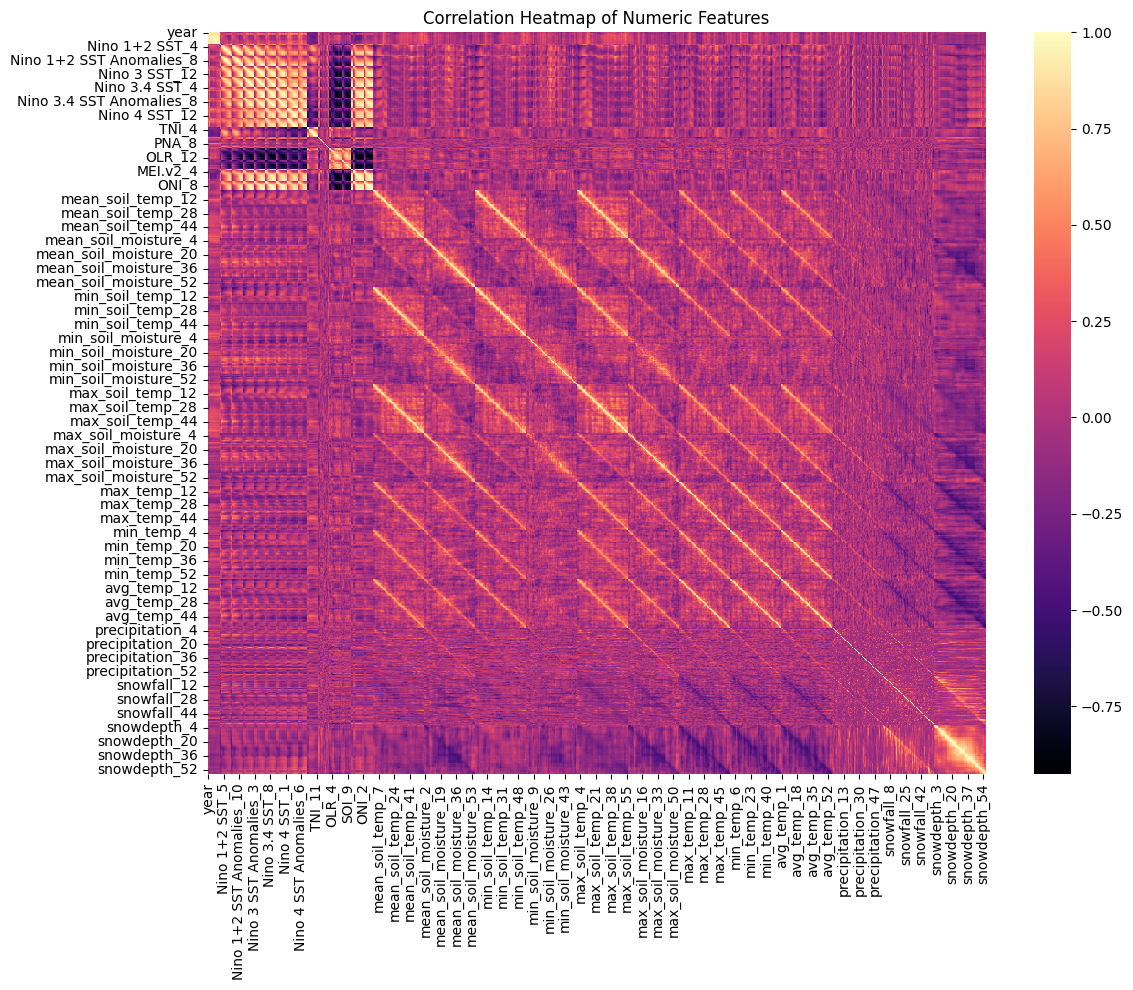

In [13]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

#### **Correlation Heatmap Of Mean And Average Features**


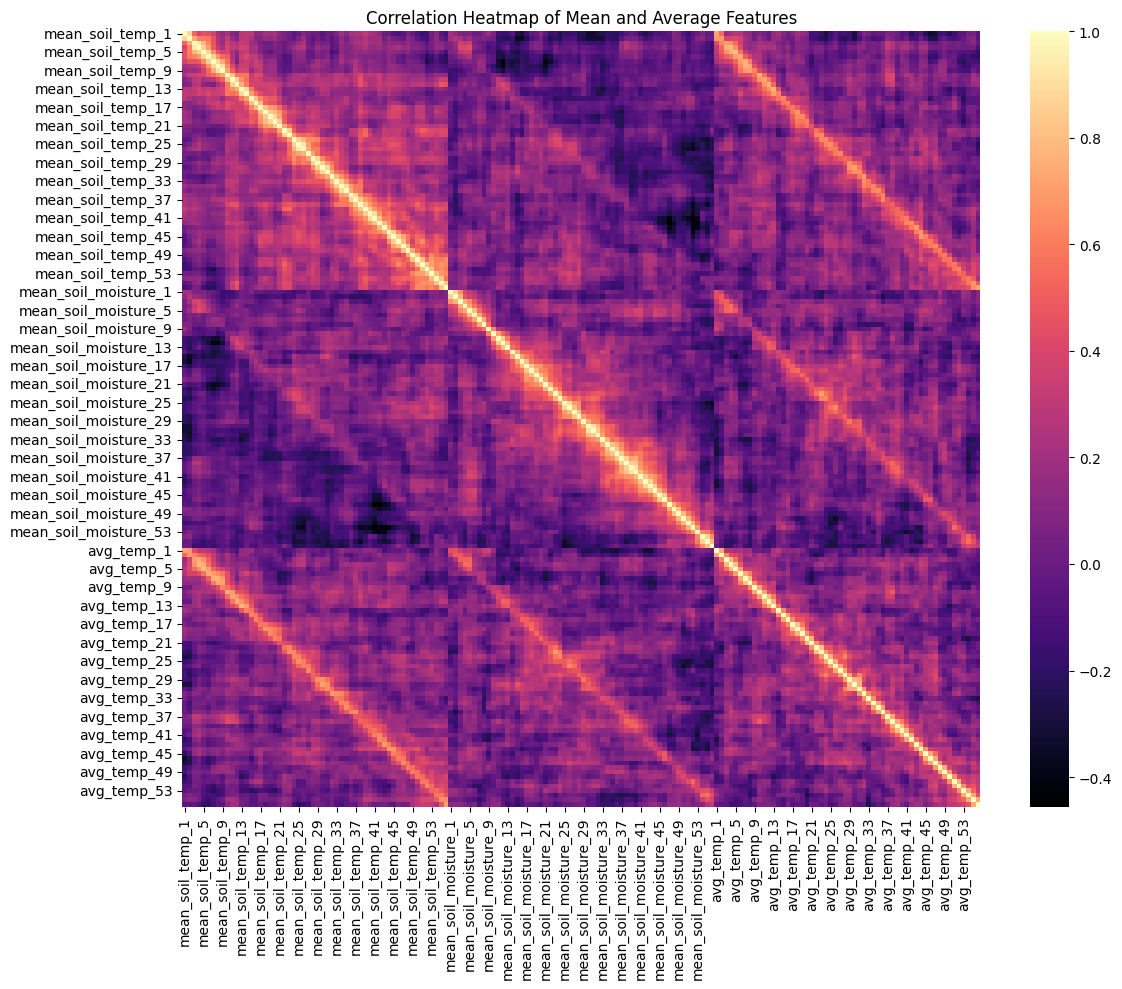

In [14]:
mean_columns = [mean for mean in data.columns if 'mean' in mean]
avg_columns = [avg for avg in data.columns if 'avg' in avg]
numeric_columns = data[mean_columns + avg_columns].select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Mean and Average Features')
plt.tight_layout()

### **Mean Soil Temperature Across Time Points**

- The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


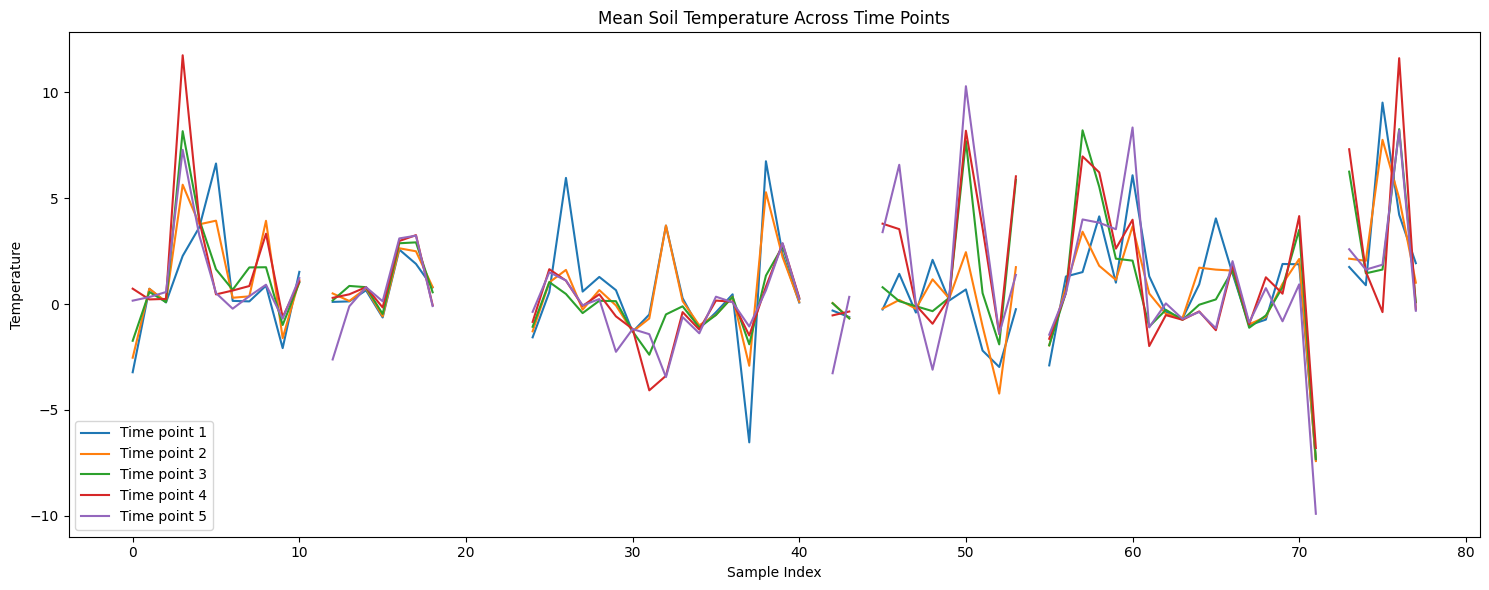

In [15]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


### **Soil Moisture Distribution**

This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


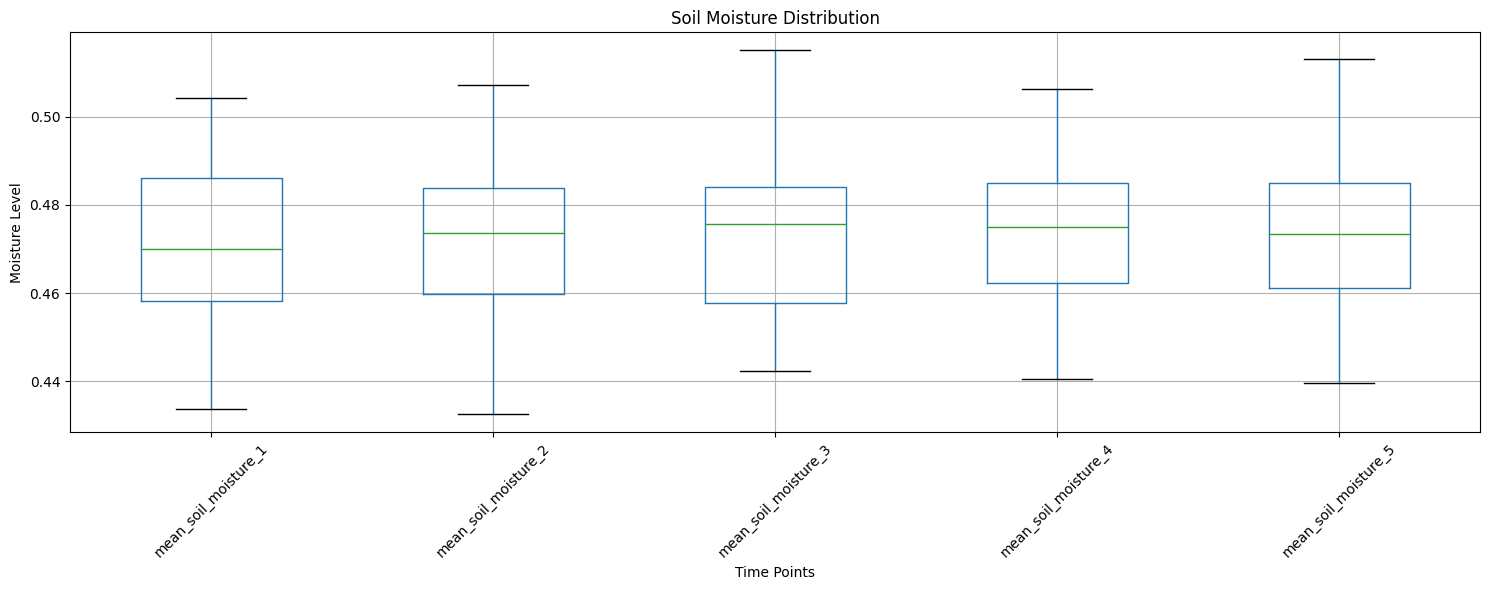

In [16]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture Relationship**


- This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

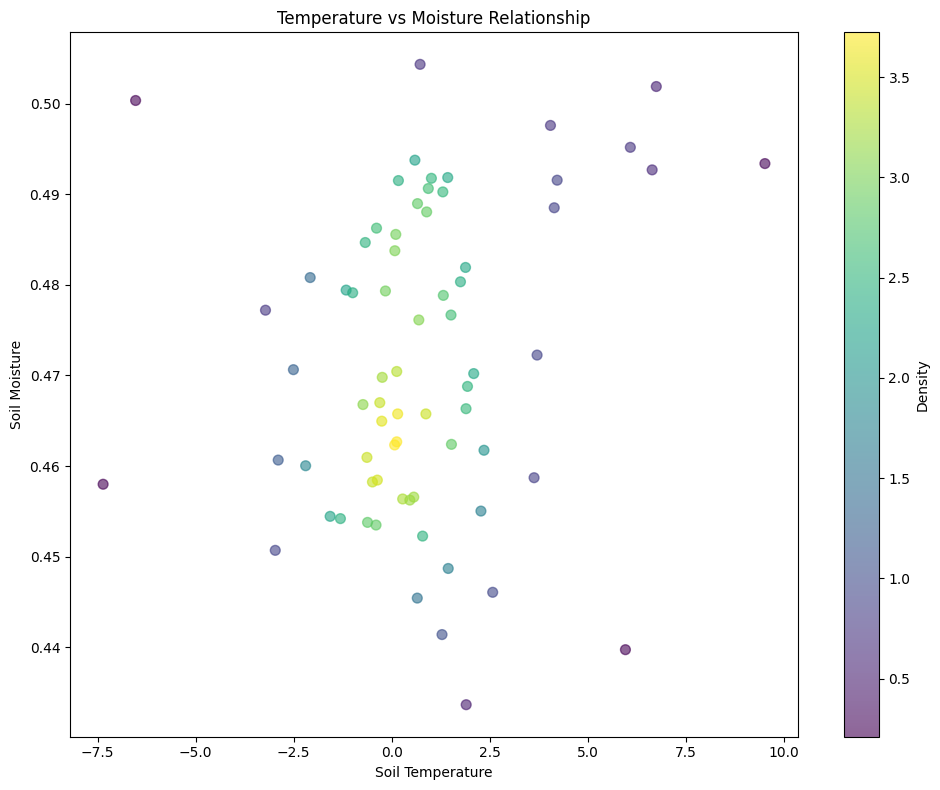

In [17]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


### **Soil Temperature Trend With Uncertainty**

The graph displays soil temperature changes from 1950 to 2020. The red line shows the average temperature, while the pink area shows how much the temperature can vary. You can see spikes in temperature around 1950, 1990, and 2015. Most of the time, the temperature stayed between -2.5°C and 5°C, but it dropped sharply to -7.5°C close to 2020.


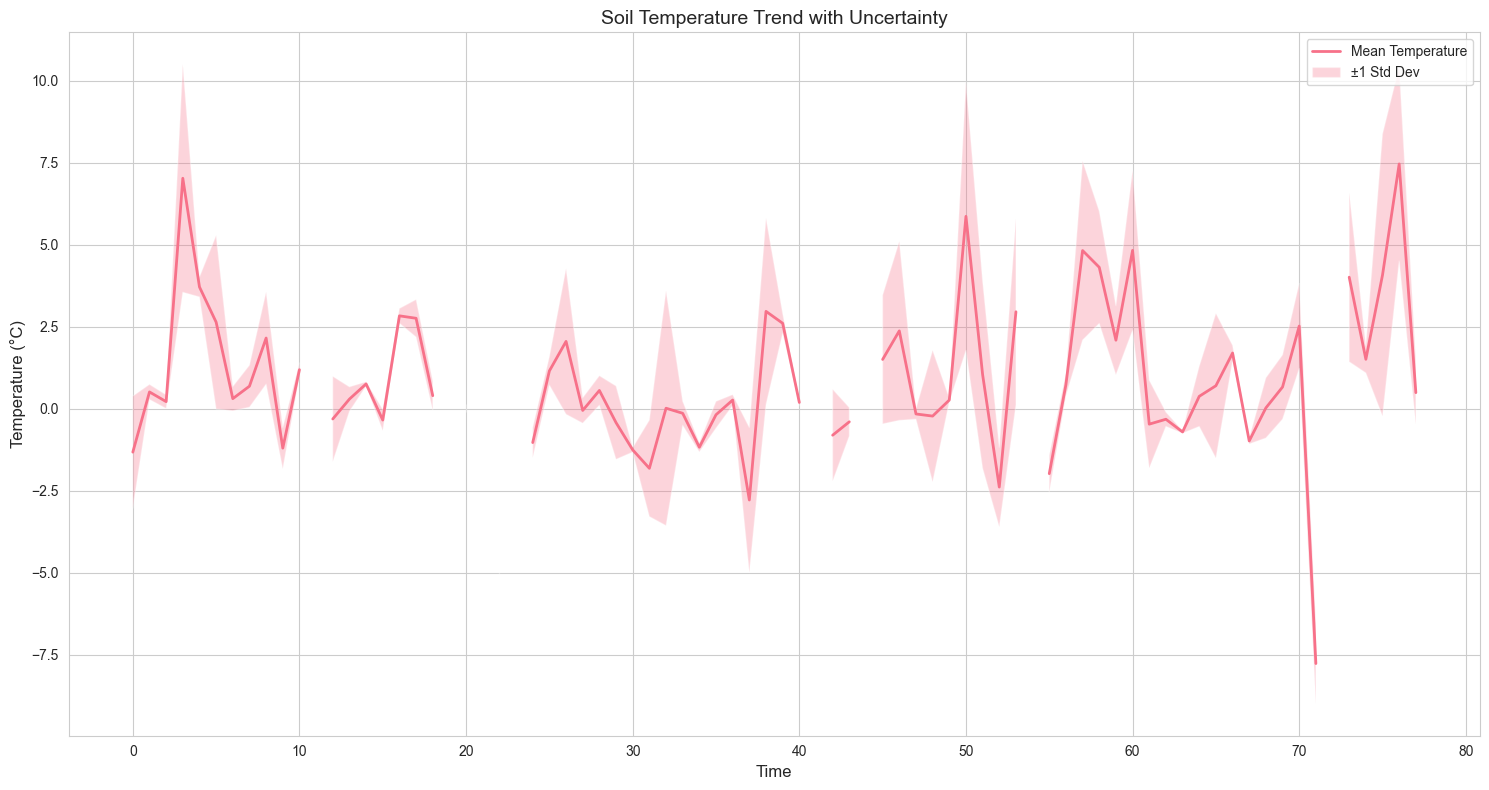

In [18]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl")

temp_mean = data[soil_temp_cols].mean(axis=1)
temp_std = data[soil_temp_cols].std(axis=1)

plt.plot(data.index, temp_mean, label='Mean Temperature', linewidth=2)
plt.fill_between(data.index, 
                 temp_mean - temp_std, 
                 temp_mean + temp_std, 
                 alpha=0.3,
                 label='±1 Std Dev')
plt.title('Soil Temperature Trend with Uncertainty', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### **Temperature Vs Moisture With Distributions**


This graph shows the relationship between soil temperature (x-axis) and soil moisture (y-axis), with histograms on the sides showing how often each value appears. The red line shows a slight positive trend, meaning that as temperature increases, moisture tends to increase a little too. However, the points are scattered, so the relationship isn't strong. The histograms indicate that most temperatures are around 0°C, while moisture levels are mostly between 0.46 and 0.49.

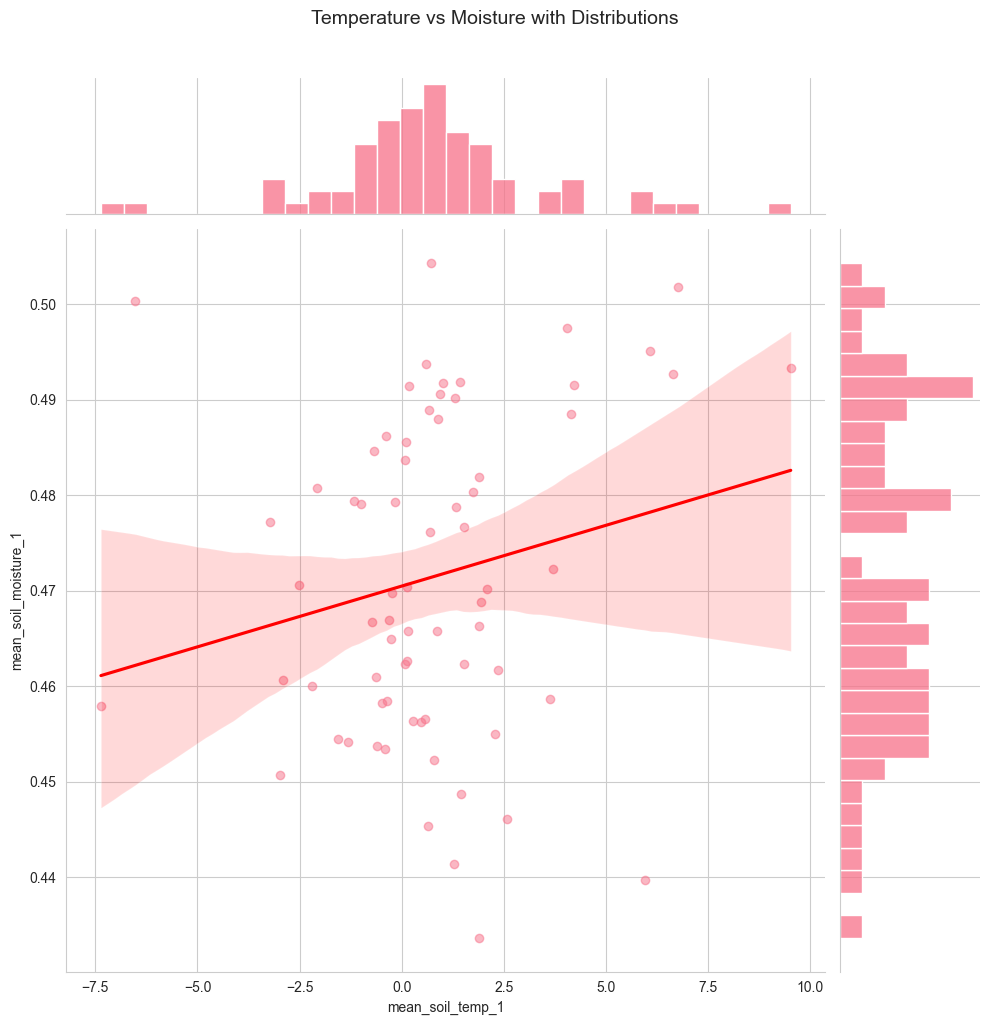

In [19]:
g = sns.JointGrid(data=data, 
                  x=soil_temp_cols[0],
                  y=moisture_cols[0],
                  height=10)
g = g.plot_joint(sns.regplot, 
                 scatter_kws={'alpha':0.5},
                 line_kws={'color': 'red'})
g = g.plot_marginals(sns.histplot, bins=30)
g.fig.suptitle('Temperature vs Moisture with Distributions', y=1.02, fontsize=14)
plt.tight_layout()


### **Temperature vs Moisture Density Distribution**


This density plot shows how soil temperature and moisture levels are distributed together. The bright yellow area around 0°C and 0.46 moisture indicates where most measurements are found. The colors range from purple (less common) to yellow (most common). There's also a purple spot at -5°C, showing a different group with higher moisture levels.

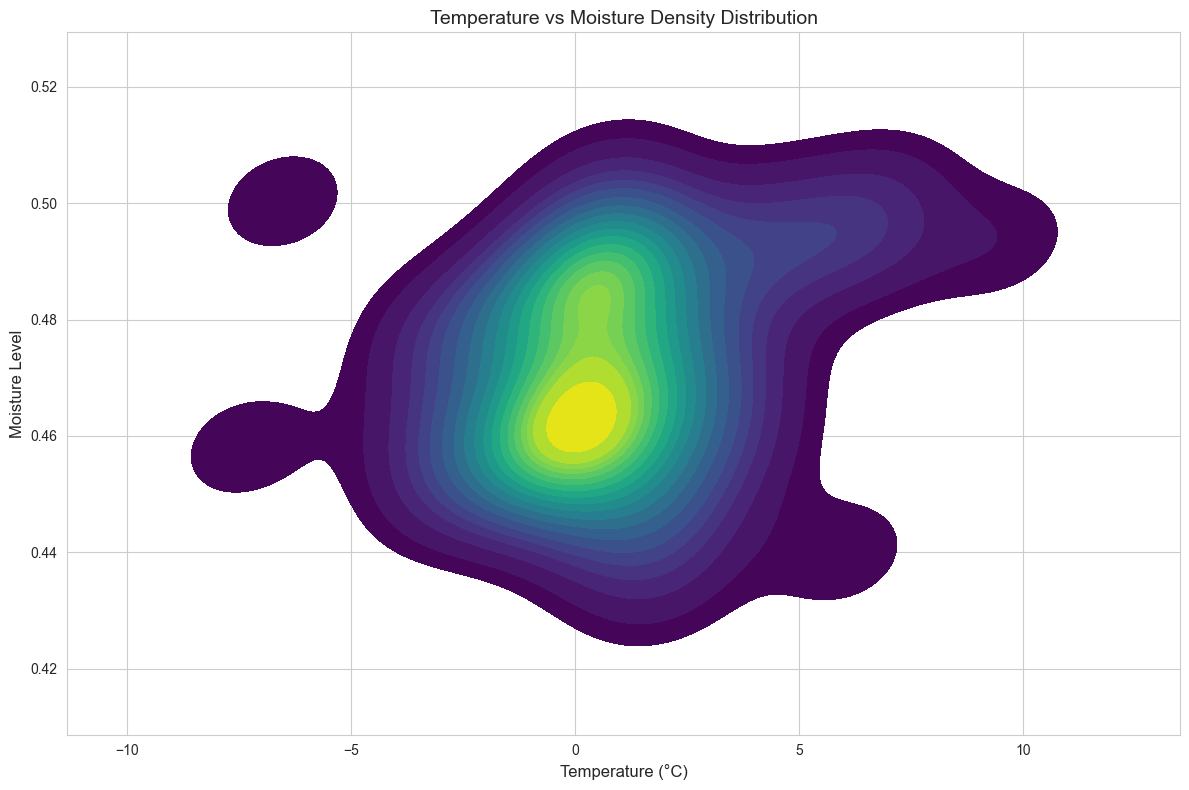

In [20]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=data,
            x=soil_temp_cols[0],
            y=moisture_cols[0],
            cmap='viridis',
            fill=True,
            levels=20)
plt.title('Temperature vs Moisture Density Distribution', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.tight_layout()
plt.show()

### **Global Temperature Anomalies Over The Years**


This graph shows how much global temperatures have deviated from a baseline average over the past 70 years, with positive numbers meaning warmer than the baseline and negative numbers meaning cooler. While there were small ups and downs from 1950 to 1980, there's been a clear warming trend since then, with temperatures rising much faster starting in the 1990s. By 2020, global temperatures were about 0.8-1.0°C warmer than they were in the 1950s, with the most dramatic increase happening in recent decades.

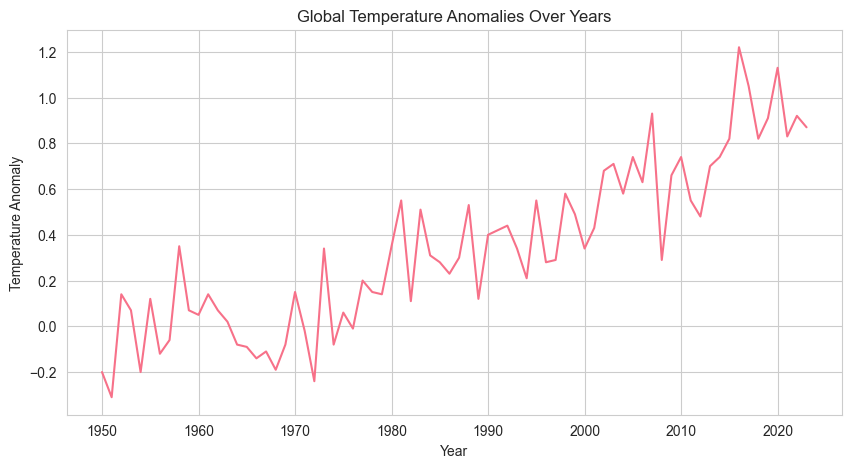

In [21]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='year', y='global temperature anomalies_1')
plt.title('Global Temperature Anomalies Over Years')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.show()


### **Correlation Matrix For Mean Soil Temperature And Precipitation**

- The correlation matrix indicates strong positive correlations (0.8-1.0) in soil temperatures at different points, especially between adjacent times (e.g., temp_1 and temp_2 at 0.88). Soil moisture has moderate correlations (0.6-0.8), while the correlation between soil temperature and moisture is weak to moderate (0.1-0.4). Precipitation shows very weak correlations with both soil temperature and moisture (mostly below 0.3), suggesting minimal immediate impact on soil conditions.


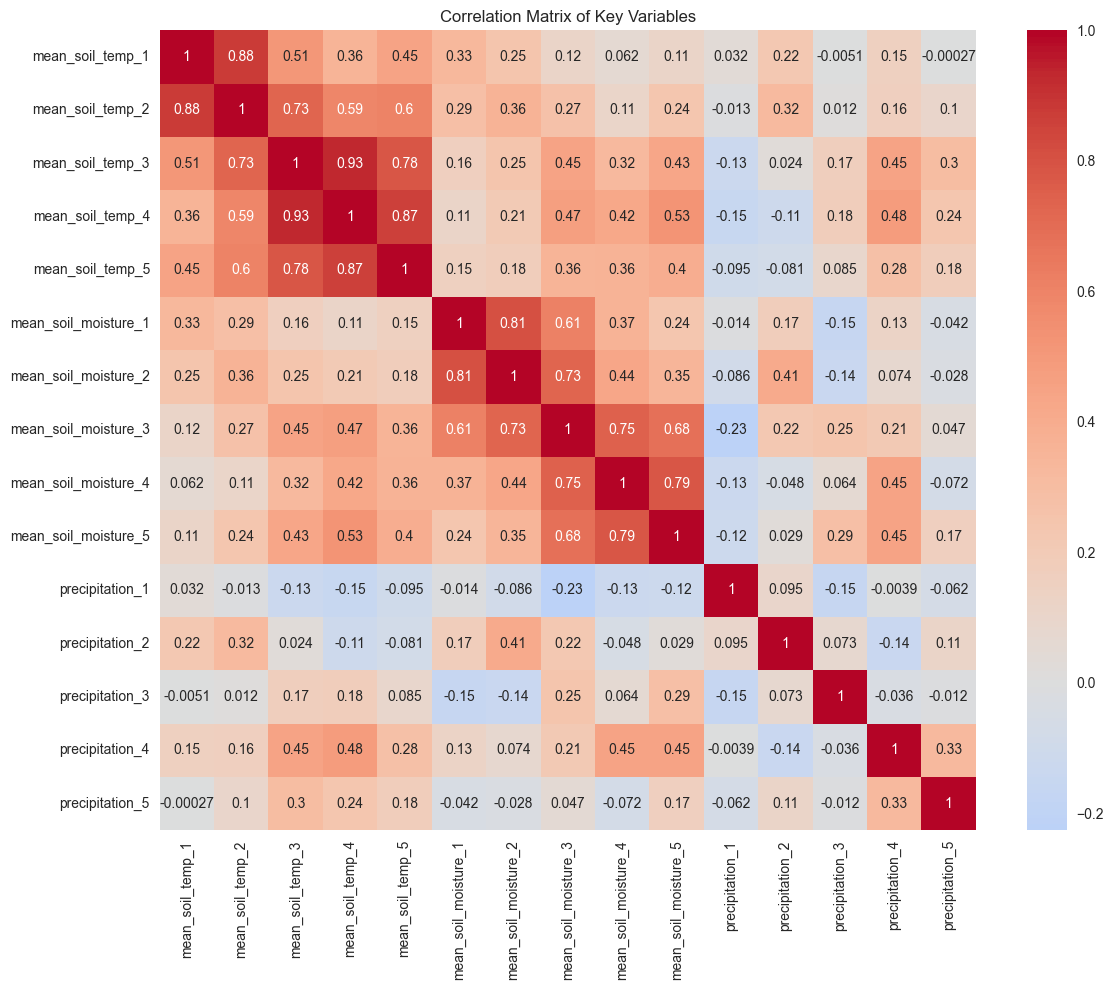

In [34]:
key_vars = (
    [col for col in data.columns if 'mean_soil_temp' in col][:5] +
    [col for col in data.columns if 'mean_soil_moisture' in col][:5] +
    [col for col in data.columns if 'precipitation' in col][:5]
)
plt.figure(figsize=(12, 10))
sns.heatmap(data[key_vars].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()


#### **Splitting The Data**

In [24]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [25]:
train_set, test_set = split_data()
data = train_set.copy()

#### **Missing Percentages**

In [26]:
missing_percentage = data.isna().mean() * 100
print(missing_percentage)

year                               0.000000
global temperature anomalies_1     4.838710
global temperature anomalies_2     4.838710
global temperature anomalies_3     4.838710
global temperature anomalies_4     4.838710
                                    ...    
snowdepth_54                      11.290323
snowdepth_55                      12.903226
snowdepth_56                      14.516129
prediction                        11.290323
early_spring                      11.290323
Length: 903, dtype: float64


#### **Removing The Empty Data From Early Spring For Later Use When Training The Model**

In [27]:
print(train_set['early_spring'].isnull().sum())
train_set = train_set.dropna(subset=['early_spring'])
print(train_set['early_spring'].isnull().sum())

7
0


# Prepare the Data

Note: the word *optional* simply means not all datasets will require it, it does not mean you can just choose not to do it if it is needed for a particular dataset.

- **A.** Data cleaning: Fix/remove outliers (optional); Fill in missing values (with 0, mean, median…) or drop rows/columns 
- **B.** Feature selection (optional): Drop attributes that provide no useful information for the task 
- **C.** Feature engineering, where appropriate: Discretize continuous features; Decompose features (categorical, date/time, …), Add promising transformations of features ($\log(x)$, $\sqrt{x}$, $x^2$, …); Aggregate features into promising new features 
- **D.** Feature scaling: standardize or normalize features 



### **Transformers**

1. **DropOldSamplesTransformer**: A custom transformer that filters out samples where the 'year' column is less than 1950. It implements the `fit` method (which does nothing) and the `transform` method, which applies the filtering.

2. **get_columns_by_type function**: This utility function takes a DataFrame as input and retrieves the lists of numerical and categorical columns by checking their data types.

3. **create_preprocessing_pipeline function**: This function defines the preprocessing pipeline. It begins by calling `get_columns_by_type` to identify the numerical and categorical columns in the input DataFrame.

   - For **numerical columns**, a pipeline is created that:
     - Imputes missing values using the mean.
     - Scales the values using `StandardScaler`.
   
   - For **categorical columns**, another pipeline is established that:
     - Imputes missing values using the most frequent value.
     - Applies one-hot encoding through `OneHotEncoder`.

4. **ColumnTransformer**: This component combines the numerical and categorical transformers, ensuring that each set of columns is processed appropriately.

5. **Final Pipeline**: The complete pipeline integrates the `DropOldSamplesTransformer` and the `ColumnTransformer` to preprocess the data.

6. **Usage**: An example shows how to create the preprocessing pipeline using a DataFrame called `data`, followed by fitting and transforming the data using the pipeline.

---


In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

# Transformer to drop samples with year < 1950
class DropOldSamplesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[X['year'] >= 1950]

# Transformer to drop columns that are completely empty


# Function to retrieve numerical and categorical columns
def get_columns_by_type(X):
    numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
    return numerical_columns, categorical_columns

# Define pipeline
def create_preprocessing_pipeline(data):
    numerical_columns, categorical_columns = get_columns_by_type(data)

    # Impute missing values and scale numerical features
    numerical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ])

    # One-hot encode categorical features
    categorical_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    # ColumnTransformer to handle both numerical and categorical columns
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

    # Final pipeline
    pipeline = Pipeline(steps=[
        ('drop_old_samples', DropOldSamplesTransformer()),
        ('preprocessing', preprocessor)
    ])

    return pipeline

# Usage example
pipeline = create_preprocessing_pipeline(data)
data_transformed = pipeline.fit_transform(data)

pipeline

Pipeline(steps=[('drop_old_samples', DropOldSamplesTransformer()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year',
                                                   'global temperature '
                                                   'anomalies_1',
                                                   'global temperature '
                                                   'anomalies_2',
                                                   'global temperature '
                                                   'anomalies_3',
                                                   'global temperature '
                                                   'anomalies_4',
                                                   'global temperatur...
                                                   'Season (3-Month)_2',
                                                   'Season (3-Month)_3',
                                                   'Season (3-Month)_4',
                                                   'Season (3-Month)_5',
                                                   'Season (3-Month)_6',
                                                   'Season (3-Month)_7',
                                                   'Season (3-Month)_8',
                                                   'Season (3-Month)_9',
                                                   'Season (3-Month)_10',
                                                   'Season (3-Month)_11',
                                                   'Season (3-Month)_12',
                                                   'Season (12-Month)_1',
                                                   'Season (12-Month)_2',
                                                   'Season (12-Month)_3',
                                                   'Season (12-Month)_4',
                                                   'Season (12-Month)_5',
                                                   'Season (12-Month)_6', ...])]))])

### **Splitting The Data Into Features And Target**

In [29]:
X = train_set.drop(columns=['early_spring'])
y = train_set['early_spring'].copy()

### **Creating The Pipeline To Do A Fit And Transform**

In [30]:
# Create the pipeline
pipeline = create_preprocessing_pipeline(X)

# Fit and transform the training features (X)
X_transformed = pipeline.fit_transform(X)

- *Had to make sure that the X and y had the same amount of samples since that changed as X was being transformed*

In [31]:
# Ensure X_transformed and y have the same number of samples
if X_transformed.shape[0] != y.shape[0]:
    # Align X and y by filtering y to match X_transformed's length
    y = y.iloc[:X_transformed.shape[0]].reset_index(drop=True)

### **Testing With Other Models**

- The Logistic Regression model achieved an accuracy of 73%, with a precision of 0.71 for class 0 and 0.75 for class 1. The recall rates were 0.83 and 0.60, respectively, resulting in an F1-score of 0.77 for class 0 and 0.67 for class 1. The confusion matrix indicated 5 true positives and 3 false negatives.

- The Linear SVC model performed slightly lower, with an overall accuracy of 64%. It recorded a precision of 0.62 for class 0 and 0.67 for class 1, while the recall values were 0.83 and 0.40, respectively. Its F1-scores were 0.71 for class 0 and 0.50 for class 1, with the confusion matrix showing 5 true positives and 3 false negatives.

- In contrast, the SVC model exhibited a high precision of 1.00 for class 0, but a lower recall of 0.33, resulting in an F1-score of 0.50. For class 1, the precision was 0.56, with a perfect recall of 1.00, leading to an F1-score of 0.71. The accuracy remained at 64%, and the confusion matrix indicated 2 true positives and 4 false negatives.

- The SGD Classifier mirrored the performance of the Logistic Regression model, achieving a 73% accuracy, with class 0 precision at 0.71 and class 1 at 0.75. The recall rates were 0.83 for class 0 and 0.60 for class 1, yielding F1-scores of 0.77 and 0.67, respectively. The confusion matrix showed 5 true positives and 3 false negatives.

- The Decision Tree model struggled, attaining an accuracy of only 36%. It exhibited a precision of 0.43 for class 0 and 0.25 for class 1, with recall rates of 0.50 and 0.20, respectively. This resulted in F1-scores of 0.46 for class 0 and 0.22 for class 1. The confusion matrix reflected 3 true positives and 4 false negatives.

- The Random Forest model had an accuracy of 55%, with precision values of 0.57 for class 0 and 0.50 for class 1. The recall rates were 0.67 for class 0 and 0.40 for class 1, leading to F1-scores of 0.62 and 0.44, respectively. The confusion matrix revealed 4 true positives and 3 false negatives.

- The Gradient Boosting model also achieved an accuracy of 55%, with a precision of 0.60 for class 0 and 0.50 for class 1. Its recall rates were 0.50 for class 0 and 0.60 for class 1, resulting in F1-scores of 0.55 for both classes. The confusion matrix showed 3 true positives and 2 false negatives.

- Similarly, the AdaBoost model achieved a 55% accuracy, with precision values of 0.60 for class 0 and 0.50 for class 1, and recall rates of 0.50 and 0.60, respectively, leading to F1-scores of 0.55 for both classes. The confusion matrix displayed 3 true positives and 2 false negatives.

- The K-Nearest Neighbors model performed comparably to the Linear SVC, with an accuracy of 64%. It had a precision of 0.62 for class 0 and 0.67 for class 1, along with recall rates of 0.83 and 0.40. The F1-scores were 0.71 for class 0 and 0.50 for class 1, while the confusion matrix indicated 5 true positives and 3 false negatives.

- Finally, the Naive Bayes model reported an accuracy of 64%, with precision at 0.60 for class 0 and a high 1.00 for class 1. However, its recall for class 0 was perfect at 1.00, while for class 1, it dropped to 0.20, yielding F1-scores of 0.75 and 0.33, respectively. The confusion matrix showed 6 true positives and 4 false negatives.



In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB


models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=1, max_iter=1000, solver='lbfgs'),  # Options: 'l1', 'elasticnet', etc.
    'Linear SVC': LinearSVC(penalty='l2', C=1, max_iter=1000, dual=False),  # Options: 'l1' penalty, 'hinge' loss, etc.
    'SVC': SVC(kernel='rbf', C=1, gamma='scale'),  # Options: 'poly' kernel, degree, gamma, etc.
    'SGD Classifier': SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1000, shuffle=True),  # Options: 'log' loss, elasticnet penalty, etc.
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2),  # Options: 'entropy' criterion, max_depth, etc.
    'Random Forest': RandomForestClassifier(n_estimators=100, max_features='sqrt', bootstrap=True),  # Options: max_samples, log2 max_features, etc.
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0),  # Options: validation_fraction, max_features, etc.
    'AdaBoost': AdaBoostClassifier(n_estimators=50, learning_rate=1.0),  # Options: adjust n_estimators and learning_rate for tuning
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='uniform'),  # Options: 'distance' weights
    'Naive Bayes': GaussianNB()
}

X_transformed = pipeline.fit_transform(X)
y = y.reset_index(drop=True).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

for name, model in models.items():
    mod = model
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"{name}:\n {report}")
    print("Confusion Matrix:")
    print(conf_matrix)

Logistic Regression:
               precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.75      0.60      0.67         5

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11

Confusion Matrix:
[[5 1]
 [2 3]]
Linear SVC:
               precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.67      0.40      0.50         5

    accuracy                           0.64        11
   macro avg       0.65      0.62      0.61        11
weighted avg       0.64      0.64      0.62        11

Confusion Matrix:
[[5 1]
 [3 2]]
SVC:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.56      1.00      0.71         5

    accuracy                           0.64        11
   macro avg       0.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### **Using Logistic Regression Model**

- Using the logistic regression model, we achieved an accuracy of approximately 63.64%. This means that about two-thirds of the predictions of model were correct. 

- True Negatives (TN): 4 (correctly predicted as False)
- False Positives (FP): 2 (incorrectly predicted as True)
- False Negatives (FN): 2 (incorrectly predicted as False)
- True Positives (TP): 3 (correctly predicted as Te)

In [33]:

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Fit and transform X, and reset index to align with the new X_transformed
X_transformed = pipeline.fit_transform(X)
y = y.reset_index(drop=True)
y = y.astype(int)

# Now split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Handle NaN values in X_train (impute with the mean)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create the Logistic Regression model
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7272727272727273
Confusion Matrix:
[[5 1]
 [2 3]]
